<a href="https://colab.research.google.com/github/charliecrook/NLP_Contract_Classification/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install transformers
from transformers import BertTokenizer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn.pipeline import Pipeline

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ContractClassificationModel

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ContractClassificationModel


___________________________
## Preprocessing Pipeline

In [4]:
from PreprocessingPipeline import SelectColumns, CombineColumns, FillNaN, OneHot, Tokenization, split_labels, split_data

In [5]:
train = pd.read_csv('german-contracts-train.csv',dtype={
      "docid":str,
      "publication_date":str,
      "contract_type":str,
      "nature_of_contract":str,
      "country_code":str,
      "country_name":str,
      "sector":str,
      "value":float,
      "title":str,
      "description":str,
      "awarding_authority":str,
      "complete_entry":str,
      "General":bool,
      "Defence":bool,
      "Education & Culture":bool,
      "Energy & Environment":bool,
      "Health & Care":bool,
      "Infrastructure & Construction":bool,
      "Professional Services":bool,
      "Technology & Communications":bool,
      "Transport & Logistics":bool,
      "label":str})
test = pd.read_csv('german-contracts-test.csv', dtype={
      "docid":str,
      "publication_date":str,
      "contract_type":str,
      "nature_of_contract":str,
      "country_code":str,
      "country_name":str,
      "sector":str,
      "value":float,
      "title":str,
      "description":str,
      "awarding_authority":str,
      "complete_entry":str,
      "General":bool,
      "Defence":bool,
      "Education & Culture":bool,
      "Energy & Environment":bool,
      "Health & Care":bool,
      "Infrastructure & Construction":bool,
      "Professional Services":bool,
      "Technology & Communications":bool,
      "Transport & Logistics":bool,
      })

In [6]:
preprocessPipe = make_pipeline(
        SelectColumns(['nature_of_contract', 'title', 'description',
                       'contract_type']), CombineColumns(['title', 'description']), 
                       FillNaN(), OneHot(), Tokenization(),)

train_X = preprocessPipe.fit_transform(train)
test_X = preprocessPipe.transform(test)
train_y = split_labels(train['label'])

In [8]:
# here we reserve a portion of the training set for out-of-sample testing after we train the model
train_X, testing_X, train_y, testing_y = train_test_split(train_X, train_y, test_size=0.15, random_state=42) 
# we split the training data further into a training and validation set
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.15, random_state=42) 

train_X = split_data(train_X)
val_X = split_data(val_X)
testing_X = split_data(testing_X)
test_X = split_data(test_X)

____________________________
## Training and testing 

Functions contained in the module named 'training_testing_functions.py', which are used during training and evaluation of the models.

In [10]:
from ClassificationModel import CNNVectorisationModel
from TrainingFunctions import train_data, performance_report, kaggle_prediction

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
2220/2220 [==============================] - 27s 11ms/step - loss: 0.8722 - accuracy: 0.7768 - val_loss: 0.0763 - val_accuracy: 0.8897
Epoch 2/50
2220/2220 [==============================] - 26s 12ms/step - loss: 0.0833 - accuracy: 0.9005 - val_loss: 0.0659 - val_accuracy: 0.9138
Epoch 3/50
2220/2220 [==============================] - 25s 11ms/step - loss: 0.0676 - accuracy: 0.9157 - val_loss: 0.0606 - val_accuracy: 0.9220
Epoch 4/50
2220/2220 [==============================] - 25s 11ms/step - loss: 0.0618 - accuracy: 0.9229 - val_loss: 0.0583 - val_accuracy: 0.9217
Epoch 5/50
2220/2220 [==============================] - 25s 11ms/step - loss: 0.0594 - accuracy: 0.9249 - val_loss: 0.0562 - val_accuracy: 0.9210
Epoch 6/50
2220/2220 [==============================] - 26s 12ms/step - loss: 0.0546 - accuracy: 0.9277 - val_loss: 0.0545 - val_accuracy: 0.9243
Epoch 7/50
2220/2220 [==============================] - 24s 11ms/step - loss: 0.0534 - accuracy: 0.9294 - val_loss: 0.0537 -

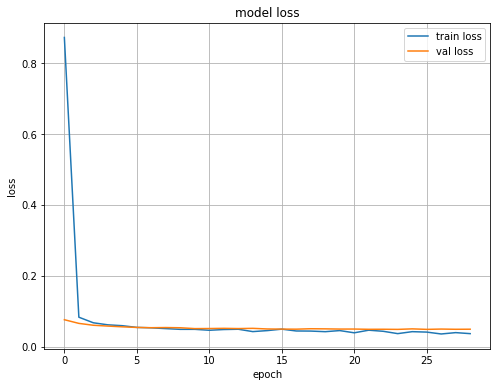

In [11]:
# Construct the model
model = CNNVectorisationModel()

# Define the early-stopping and performance scheduling callbacks
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=5, 
                                                  restore_best_weights=True)

# Fit the model to the training data
history = train_data(train_X, train_y, 
                val_X, val_y, 
                model=model, 
                loss='binary_crossentropy', 
                optimizer=keras.optimizers.Adam(lr=1e-3), 
                epochs=50,
                batch_size=32,
                callbacks=[early_stopping_cb],
                model_version='CNNVectorisation_1_1',
                model_name='CNNVectorisation')

In [12]:
# Examine the performance on the testing data
performance_report(testing_X, testing_y, model)

461/461 [==============================] - 2s 4ms/step - loss: 0.0489 - accuracy: 0.9301
total loss: [0.048907678574323654, 0.9300922155380249]
Global accuracy: 0.9098182804448061
Global f1 score: 0.9410542355844226


[[[13291    92]
  [  318  1047]]

 [[14380    26]
  [  139   203]]

 [[14239    15]
  [   88   406]]

 [[13574    29]
  [  132  1013]]

 [[13772    14]
  [  125   837]]

 [[ 5725   147]
  [  173  8703]]

 [[13476    28]
  [  174  1070]]

 [[14091    18]
  [  139   500]]

 [[13591    23]
  [  102  1032]]]


In [20]:
# Create Kaggle csv submission file
result_ids = pd.DataFrame(test['docid'])
kaggle_prediction(test_X, result_ids, model, '/content/drive/MyDrive/ContractClassificationModel/CNNVectorisationSubmission.csv')